In [104]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score

In [107]:
df_history = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_train_v2.csv')
df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_dualnn.csv')

df_results['pred_winner'] = np.where(df_results['correct_pred']==1, df_results['winner'], np.abs(1-df_results['winner']))
df_results['Date'] = df_results["event_dates"].copy()
df_results.sort_values(by='Date', ascending=True).reset_index(drop=True)

df_results['prob_winner'] = df_results[['red_probs','blue_probs']].max(axis=1)
df_results['winner_odds'] = np.where(df_results['winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['choice_fighter_bet'] = np.where(df_results['pred_winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['Date'] = df_results["Date"].astype(str)

df_correct_pred = df_results[df_results["correct_pred"] == 1].copy() 
df_incorrect_pred = df_results[df_results["correct_pred"] == 0].copy()

pred_correct_odds = df_results[df_results["correct_pred"] == 1]['choice_fighter_bet'].value_counts().sort_index()
pred_incorrect_odds = df_results[df_results["correct_pred"] == 0]['choice_fighter_bet'].value_counts().sort_index()

from collections import defaultdict
def fighter_prediction_stats(df, pred_col='pred_winner', red_col='red_fighter', blue_col='blue_fighter', winner_col='winner'):
    
    stats = defaultdict(lambda: {'correct': 0, 'incorrect': 0})
    for _, row in df.iterrows():
        red_fighter = row[red_col]
        blue_fighter = row[blue_col]
        winner = row[winner_col]
        pred = row[pred_col]
        
        if pred == winner :
            if pred == 1: 
                stats[red_fighter]['correct'] += 1
            else: 
                stats[blue_fighter]['correct'] += 1
        else:
            if pred == 1: 
                stats[red_fighter]['incorrect'] += 1
            else:
                stats[blue_fighter]['incorrect'] += 1
    
    return stats

preds_results_dict = fighter_prediction_stats(df_history)


In [ ]:
    df['choice_ud_to_fav_close1'] = (df['choice_open'] > 0) & (df['choice_close1'] < 0).astype(int)
    df['choice_ud_to_fav_close2'] = (df['choice_open'] > 0) & (df['choice_close2'] < 0).astype(int)

    df['choice_stayed_fav_close1'] = (df['choice_open'] < 0) & (df['choice_close1'] < 0).astype(int)
    df['choice_stayed_fav_close2'] = (df['choice_open'] < 0) & (df['choice_close2'] < 0).astype(int)

    df['choice_fav_to_ud_close1'] = (df['choice_open'] < 0) & (df['choice_close1'] > 0).astype(int)
    df['choice_fav_to_ud_close2'] = (df['choice_open'] < 0) & (df['choice_close2'] > 0).astype(int)

    df['choice_stayed_dog_close1'] = (df['choice_open'] > 0) & (df['choice_close1'] > 0).astype(int)
    df['choice_stayed_dog_close2'] = (df['choice_open'] > 0) & (df['choice_close2'] > 0).astype(int)

In [108]:
print(accuracy_score(df_results['winner'], df_results['pred_winner']))

0.6950732356857523


In [ ]:
def calc_net_odds(df_):
    df = df_.copy()
    pred_open_net = []
    pred_close1_net = []
    pred_close2_net = []
    
    for _, row in df.iterrows():
        pred_open_net.append(calc_choice_net(row, 'dec_open_red', 'dec_open_blue'))
        pred_close1_net.append(calc_choice_net(row, 'dec_close1_red', 'dec_close1_blue'))
        pred_close2_net.append(calc_choice_net(row, 'dec_close2_red', 'dec_close2_blue'))

    df['choice_winner'] = np.where(df['pred_winner'] == df['winner'], 1, 0)

    df['choice_open_net'] = pred_open_net
    df['choice_close1_net'] = pred_close1_net
    df['choice_close2_net'] = pred_close2_net

    df['choice_proba'] = np.where(df['pred_winner']==1, df['red_probs'], df['blue_probs'])
    df['choice_dec_open'] = np.where(df['pred_winner']==1, df['dec_open_red'], df['dec_open_blue'])
    df['choice_dec_close1'] = np.where(df['pred_winner']==1, df['dec_close1_red'], df['dec_close1_blue'])
    df['choice_dec_close2'] = np.where(df['pred_winner']==1, df['dec_close2_red'], df['dec_close2_blue'])

    ev_red_open = expected_value(df['red_probs'], df['dec_open_red'])
    ev_blue_open = expected_value(df['blue_probs'], df['dec_open_blue'])
    ev_red_close1 = expected_value(df['red_probs'], df['dec_close1_red'])
    ev_blue_close1 = expected_value(df['blue_probs'], df['dec_close1_blue'])
    ev_red_close2 = expected_value(df['red_probs'], df['dec_close1_red'])
    ev_blue_close2 = expected_value(df['blue_probs'], df['dec_close1_blue'])
    
    df['choice_ev_open'] = df['choice_proba'] * np.where(
        df['pred_winner'] == 1, ev_red_open, ev_blue_open
    )

    df['choice_ev_close1'] = df['choice_proba'] * np.where(
        df['pred_winner'] == 1, ev_red_close1, ev_blue_close1
    )

    df['choice_ev_close2'] = df['choice_proba'] * np.where(
        df['pred_winner'] == 1, ev_red_close2, ev_blue_close2
    )

    df[['choice_count_correct', 'choice_count_incorrect']] = count_right_wrong(df)

    df['choice_pimp_open'] = np.where(df['pred_winner']==1, df['pimp_open_red'], df['pimp_open_blue']) 
    df['choice_pimp_close1'] = np.where(df['pred_winner']==1, df['pimp_close1_red'], df['pimp_close1_blue'])
    df['choice_pimp_close2'] = np.where(df['pred_winner']==1, df['pimp_close2_red'], df['pimp_close2_blue'])

    df['choice_juice_open'] = np.where(df['pred_winner']==1, df['juice_open_red'], df['juice_open_blue']) 
    df['choice_juice_close1'] = np.where(df['pred_winner']==1, df['juice_close1_red'], df['juice_close1_blue']) 
    df['choice_juice_close2'] = np.where(df['pred_winner']==1, df['juice_close2_red'], df['juice_close2_blue']) 

    df['choice_fair_dec_open'] = np.where(df['pred_winner'] == 1, df['dec_fair_open_red'], df['dec_fair_open_blue'])
    df['choice_fair_dec_close1'] = np.where(df['pred_winner'] == 1, df['dec_fair_close1_red'], df['dec_fair_close1_blue'])
    df['choice_fair_dec_close2'] = np.where(df['pred_winner'] == 1, df['dec_fair_close2_red'], df['dec_fair_close2_blue'])

    df['choice_open'] = np.where(df['pred_winner']==1, df['open_red'], df['open_blue'])
    df['choice_close1'] = np.where(df['pred_winner']==1, df['close1_red'], df['close1_blue'])
    df['choice_close2'] = np.where(df['pred_winner']==1, df['close2_red'], df['close2_blue'])

    df['choice_line_movement_close1'] = np.where(df['pred_winner']==1, df['line_movement_close1_red'], df['line_movement_close1_blue'])
    df['choice_line_movement_close2'] = np.where(df['pred_winner']==1, df['line_movement_close2_red'], df['line_movement_close2_blue'])

    df['choice_juice_open'] = np.where(df['pred_winner']==1, df['juice_open_red'], df['juice_open_blue'])
    df['choice_juice_close1'] = np.where(df['pred_winner']==1, df['juice_close1_red'], df['juice_close1_blue'])
    df['choice_juice_close2'] = np.where(df['pred_winner']==1, df['juice_close2_red'], df['juice_close2_blue'])

    df['choice_edge_open'] = np.where(df['pred_winner']==1, df['edge_open_red'], df['edge_open_blue'])
    df['choice_edge_close1'] = np.where(df['pred_winner']==1, df['edge_close1_red'], df['edge_close1_blue'])
    df['choice_edge_close2'] = np.where(df['pred_winner']==1, df['edge_close2_red'], df['edge_close2_blue'])

    df['choice_ud_to_fav_close1'] = (df['choice_open'] > 0) & (df['choice_close1'] < 0).astype(int)
    df['choice_ud_to_fav_close2'] = (df['choice_open'] > 0) & (df['choice_close2'] < 0).astype(int)

    df['choice_stayed_fav_close1'] = (df['choice_open'] < 0) & (df['choice_close1'] < 0).astype(int)
    df['choice_stayed_fav_close2'] = (df['choice_open'] < 0) & (df['choice_close2'] < 0).astype(int)

    df['choice_fav_to_ud_close1'] = (df['choice_open'] < 0) & (df['choice_close1'] > 0).astype(int)
    df['choice_fav_to_ud_close2'] = (df['choice_open'] < 0) & (df['choice_close2'] > 0).astype(int)

    df['choice_stayed_dog_close1'] = (df['choice_open'] > 0) & (df['choice_close1'] > 0).astype(int)
    df['choice_stayed_dog_close2'] = (df['choice_open'] > 0) & (df['choice_close2'] > 0).astype(int)

    return df

def expected_value(p, o):
    EV = p * (o - 1) - (1 - p) * 1
    return EV 

def calc_choice_net(row, dec_red, dec_blue):
    pred_net = 0
    if row['pred_winner'] == 1 and row['winner'] == 1:
        pred_net = row[dec_red] - 1
        
    elif row['pred_winner'] == 1 and row['winner'] != 1:
        pred_net = -1

    elif row['pred_winner'] == 0 and row['winner'] == 0:
        pred_net = row[dec_blue] - 1
        
    elif row['pred_winner'] == 0 and row['winner'] != 0:
        pred_net = -1

    return pred_net

def count_right_wrong(df, pred_col='pred_winner', red_col='red_fighter', blue_col='blue_fighter', winner_col='winner'):
    choice_correct = []
    choice_incorrect = []

    stats = defaultdict(lambda: {'correct': 0, 'incorrect': 0})
    for _, row in df.iterrows():
        red_fighter = row[red_col]
        blue_fighter = row[blue_col]
        winner = row[winner_col]
        pred = row[pred_col]

        choice_fighter = red_fighter if pred==1 else blue_fighter
        choice_correct.append(stats[choice_fighter]['correct'])
        choice_incorrect.append(stats[choice_fighter]['incorrect'])

        if pred == winner:
            if pred == 1: 
                stats[red_fighter]['correct']  += 1
            else: 
                stats[blue_fighter]['correct'] += 1
        else:
            if pred == 1: 
                stats[red_fighter]['incorrect'] += 1
            else:
                stats[blue_fighter]['incorrect'] += 1
    
    return np.column_stack([choice_correct, choice_incorrect])


df_history = calc_net_odds(df_history)
df_results = calc_net_odds(df_results)

In [155]:

X_names = [ 'choice_proba','choice_dec_open', 'choice_dec_close1', 'choice_dec_close2',
            'choice_ev_close1', 'choice_ev_close2', 'choice_pimp_open', 'choice_pimp_close1', 'choice_pimp_close2', 
            'choice_fair_dec_open', 'choice_fair_dec_close1', 'choice_fair_dec_close2', 'choice_open', 'choice_close1', 'choice_close2',
            'choice_line_movement_close1', 'choice_line_movement_close2', 'choice_juice_open', 'choice_juice_close1', 'choice_juice_close2',
            'choice_edge_open', 'choice_edge_close1', 'choice_edge_close2', 'choice_ud_to_fav_close1', 'choice_ud_to_fav_close2', 'choice_stayed_fav_close1',
            'choice_stayed_fav_close2', 'choice_fav_to_ud_close1', 'choice_fav_to_ud_close2', 'choice_stayed_dog_close1', 'choice_stayed_dog_close2']

X_continuous_names = ['choice_proba','choice_pimp_open', 'choice_pimp_close1', 'choice_pimp_close2',
                    'choice_ev_close1', 'choice_ev_close2','choice_ev_open',
                    'choice_dec_open', 'choice_dec_close1', 'choice_dec_close2',
                    'choice_fair_dec_open', 'choice_fair_dec_close1', 'choice_fair_dec_close2', 
                    'choice_open', 'choice_close1', 'choice_close2',
                    'choice_line_movement_close1', 'choice_line_movement_close2', 'choice_juice_open', 'choice_juice_close1', 'choice_juice_close2',
                    'choice_edge_open', 'choice_edge_close1', 'choice_edge_close2',
                    'choice_count_correct', 'choice_count_incorrect'
                    ]

X_discrete_names = ['choice_ud_to_fav_close1', 'choice_ud_to_fav_close2', 
            'choice_stayed_fav_close1', 'choice_stayed_fav_close2',
            'choice_stayed_dog_close1', 'choice_stayed_dog_close2', 
            'choice_fav_to_ud_close1', 'choice_fav_to_ud_close2',]

X_close1 = [c for c in X_names if ('close1' in c or 'open' in c)]
X_close2 = [c for c in X_names if ('close2' in c or 'open' in c)] 

X_close1_cont = [c for c in X_continuous_names if ('close1' in c or 'open' in c)]
X_close2_cont = [c for c in X_continuous_names if ('close2' in c or 'open' in c)]

X_close1_discrete = [c for c in X_discrete_names if ('close1' in c or 'open' in c)]
X_close2_discrete = [c for c in X_discrete_names if ('close2' in c or 'open' in c)]

y_vals = ['choice_open_net', 'choice_close1_net', 'choice_close2_net', 'winner', 'choice_correct_pred', 'pred_winner']
print(len(X_continuous_names)+len(X_discrete_names), len(X_names))


34 31


In [158]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

y_vals = ['choice_open_net', 'choice_close1_net', 'choice_close2_net', 'winner', 'choice_winner', 'pred_winner']


choice_ud_to_fav_close1
choice_stayed_fav_close1
choice_stayed_dog_close1
choice_fav_to_ud_close1


C:\Users\jcmar\AppData\Local\Temp\ipykernel_32428\3429661946.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = X_test_pop[X_train_pop[subset] == 1]
C:\Users\jcmar\AppData\Local\Temp\ipykernel_32428\3429661946.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = X_test_pop[X_train_pop[subset] == 1]
C:\Users\jcmar\AppData\Local\Temp\ipykernel_32428\3429661946.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = X_test_pop[X_train_pop[subset] == 1]
C:\Users\jcmar\AppData\Local\Temp\ipykernel_32428\3429661946.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = X_test_pop[X_train_pop[subset] == 1]


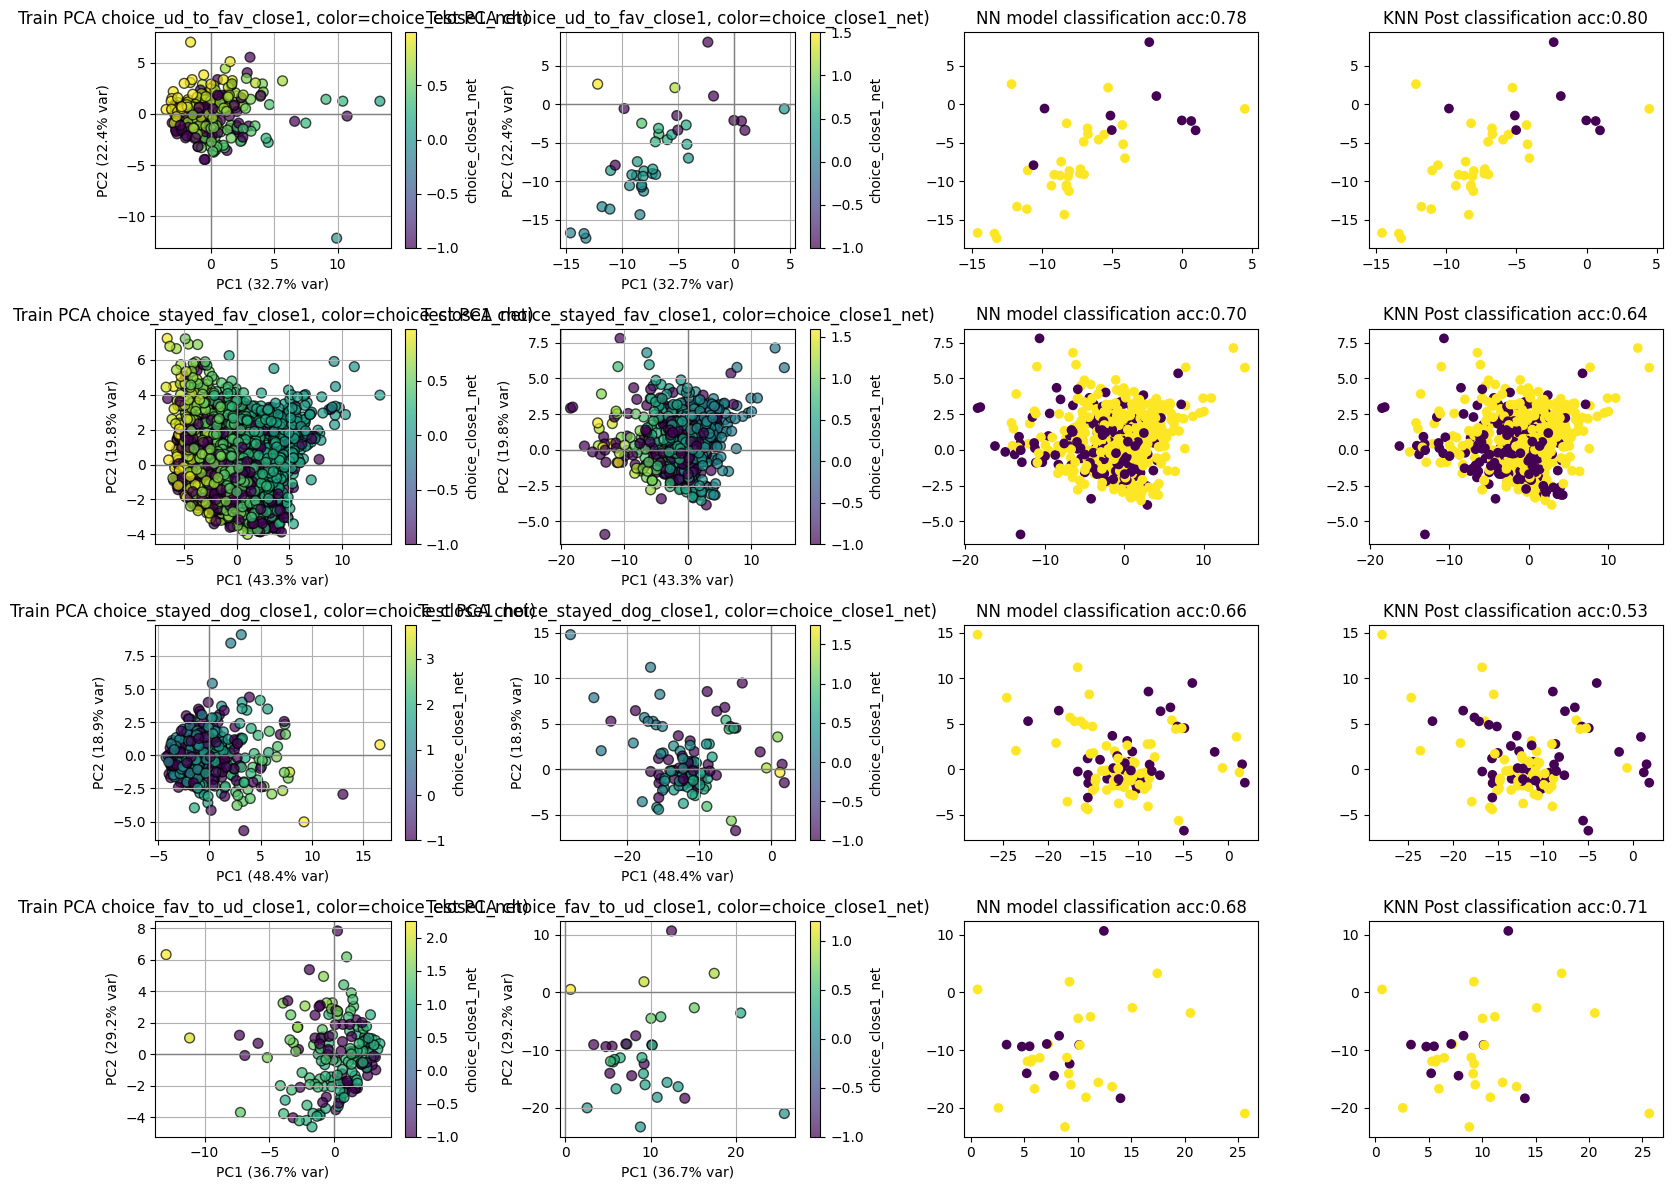

In [170]:
def pca_pipeline(X_history, X_results, cont_c, disc_c, count_c, y_vals):

    fig, axes = plt.subplots(nrows=len(disc_c), ncols=4, figsize=(16,12))
    pop_cols = cont_c + disc_c + count_c + y_vals
    X_train_pop = X_history[pop_cols].copy()
    X_test_pop = X_results[pop_cols].copy()
    scaler = StandardScaler()

    for i, subset in enumerate(disc_c): 
        print(subset)

        train = X_train_pop[X_train_pop[subset] == 1]
        test = X_test_pop[X_train_pop[subset] == 1]

        X_train = scaler.fit_transform(train[cont_c+count_c])
        # y_train = train['winner']
        X_test = scaler.transform(test[cont_c+count_c])

        pca = PCA(n_components=.95)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        train_explained_var = pca.explained_variance_ratio_

        pca_results = [X_train_pca, X_test_pca]
        data_sets = [train, test]
        titles = ['Train', 'Test']
        color_col = 'choice_close1_net'
        for j in range(2):
            xs = pca_results[j][:, 0]
            ys = pca_results[j][:, 1]
            colors = data_sets[j][color_col]

            sc = axes[i, j].scatter(xs, ys, c=colors, cmap='viridis', alpha=0.7, edgecolor='k', s=50)

            axes[i, j].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
            axes[i, j].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
            axes[i, j].set_title(f'{titles[j]} PCA {subset}, color={color_col})')

            fig.colorbar(sc, ax=axes[i, j], label=color_col)
            axes[i, j].grid(True)
            axes[i, j].axhline(0, color='grey', lw=1)
            axes[i, j].axvline(0, color='grey', lw=1)


        knn = KNeighborsClassifier(n_neighbors=5)
        n_components = 10
        X_train_knn = X_train_pca[:,:n_components] 
        y_train = train['choice_winner']

        X_test_knn = X_test_pca[:,:n_components] 
        y_test = test['choice_winner']

        knn.fit(X_train_knn, y_train)
        y_pred = knn.predict(X_test_knn)
        acc = accuracy_score(y_test, y_pred)

        xs = pca_results[j][:, 0]
        ys = pca_results[j][:, 1]

        y_preds = [test['pred_winner'], y_pred]
        y_tests = [test['winner'], y_test]
        titles = ['NN model', 'KNN Post']
        for j in range(2):
            colors = np.where(y_preds[j]==y_tests[j],1,0)
            
            acc = accuracy_score(y_tests[j], y_preds[j])
            axes[i,2+j].scatter(xs, ys, c = colors)
            axes[i,2+j].set_title(f'{titles[j]} classification acc:{acc:.2f}')

    plt.tight_layout()
    plt.show()

count_correct_names = ['choice_count_correct', 'choice_count_incorrect']                   
pca_pipeline(df_history, df_results, X_close1_cont, X_close1_discrete, count_correct_names, y_vals)
    

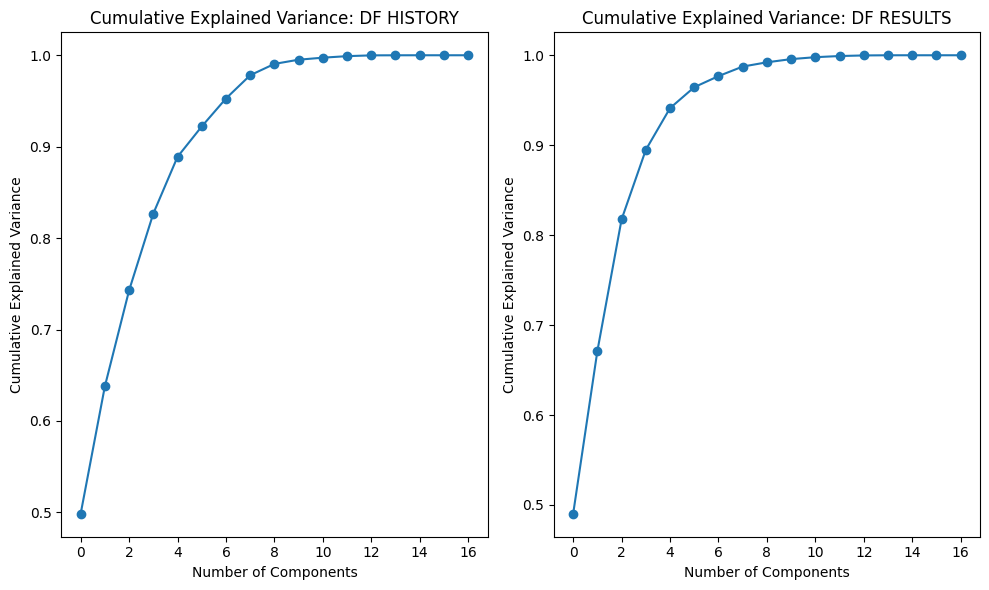

In [135]:
X_continuous_history = df_history[X_close1_cont+['choice_count_correct', 'choice_count_incorrect']]
X_continuous_results = df_results[X_close1_cont+['choice_count_correct', 'choice_count_incorrect']]

scaler = StandardScaler()
X_scaled_history = scaler.fit_transform(X_continuous_history)

pca = PCA(n_components=X_scaled_history.shape[1])
X_pca_history = pca.fit_transform(X_scaled_history)
explained_var_history = pca.explained_variance_ratio_

X_scaled_results = scaler.transform(X_continuous_results)
X_pca_results_projected = pca.transform(X_scaled_results)

pca_results = PCA(n_components=X_scaled_results.shape[1])
X_pca_results = pca_results.fit_transform(X_scaled_results)
explained_var_results = pca_results.explained_variance_ratio_

fig, axes = plt.subplots(ncols=2, figsize=(10,6))
axes[0].plot(np.cumsum(explained_var_history), marker='o')
axes[1].plot(np.cumsum(explained_var_results), marker='o')

titles = ['DF HISTORY', 'DF RESULTS']
for i, ax in enumerate(axes): 
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance')
    ax.set_title(f'Cumulative Explained Variance: {titles[i]}')

plt.tight_layout()
plt.show()


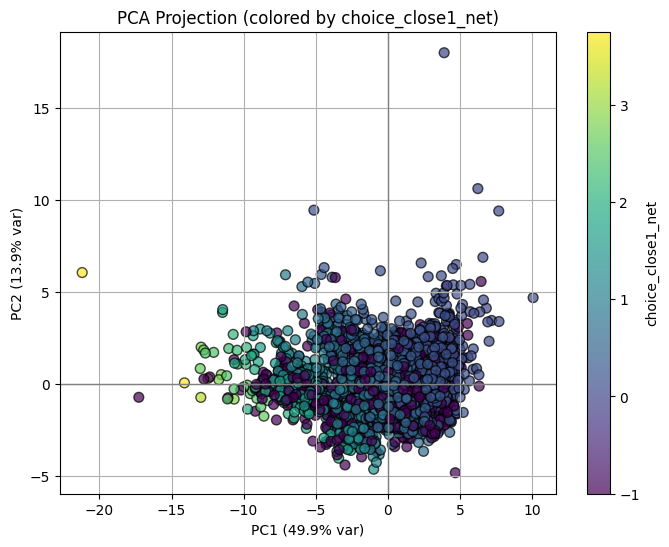

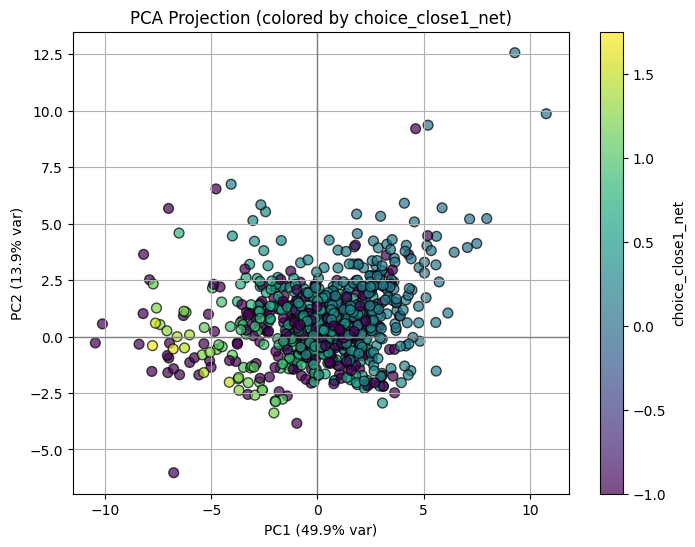

In [136]:
# Example: color by 'net_odds' (change this to any column you want)
color_col = 'choice_close1_net'

# Get the PCA components
xs = X_pca_history[:, 0]
ys = X_pca_history[:, 1]

# Get the color values from the dataframe
colors = df_history[color_col]

plt.figure(figsize=(8, 6))
sc = plt.scatter(xs, ys, c=colors, cmap='viridis', alpha=0.7, edgecolor='k', s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title(f'PCA Projection (colored by {color_col})')
plt.colorbar(sc, label=color_col)
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

# Get the PCA components
xs = X_pca_results_projected[:, 0]
ys = X_pca_results_projected[:, 1]

# Get the color values from the dataframe
colors = df_results[color_col]

plt.figure(figsize=(8, 6))
sc = plt.scatter(xs, ys, c=colors, cmap='viridis', alpha=0.7, edgecolor='k', s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title(f'PCA Projection (colored by {color_col})')
plt.colorbar(sc, label=color_col)
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

In [ ]:
df_v2 = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\entire_odds_stats_v2.csv')
df_model = df_v2.copy()
df_model = df_model.dropna()

feat_select_cols = ['reach_blue', 'reach_red', 'reach_diff', 'age_diff', 'blue_age', 'red_age', 'height_blue', 'height_red',
                     'weight_class', 'total_bonus_red', 'total_bonus_blue',
                      'total_bonus_diff', 'reverse_pr_blue', 'reverse_pr_red', 'total_td_defended_diff', 'red_td_landed_total',
                      'blue_td_landed_total', 'red_td_defended_total', 'blue_td_defended_total', 
                      'total_td_landed_diff', 'red_kd_total', 'blue_kd_total', 'kd_total_diff', 'math_red', 
                     'math_blue', 'months_since_red', 'months_since_blue', 'months_since_diff', 'red_win_streak', 'red_lose_streak', 'blue_win_streak', 
                     'blue_lose_streak', 'win_pct_red', 'win_pct_blue', 'num_fights_red', 'num_fights_blue', 'num_wins_red', 'num_wins_blue', 
                     'num_losses_red', 'num_losses_blue', 'num_fights_diff', 'win_streak_diff',
                       'lose_streak_diff', 'wins_diff', 'losses_diff', 'decision_wins_red', 'ko_wins_red', 
                     'sub_wins_red', 'decision_wins_blue', 'ko_wins_blue', 'sub_wins_blue', 'decision_wins_diff', 'ko_wins_diff',
                      'sub_wins_diff', 'open_blue', 'open_red', 'red_fav_counts', 'red_dog_counts', 'blue_fav_counts', 'blue_dog_counts']

final_df = df_model[df_model['winner']!=2].dropna().copy()
train_len = int(final_df.shape[0] * .85)

df_train = final_df.iloc[:train_len]
df_test = final_df.iloc[train_len:]

print(df_train.shape, df_history.shape)
df_history['date'] = df_history['event_dates'].copy()
df_results['date'] = df_results['event_dates'].copy()

df_train_merge = pd.merge(df_train.reset_index(), df_history.reset_index(), on=['date', 'winner', 'red_fighter', 'blue_fighter', 'open_red', 'open_blue', 'close1_red', 'close1_blue', 'close2_red', 'close2_blue'])
df_test_merge = pd.merge(df_results.reset_index(), df_test.reset_index(), on=['date', 'winner', 'red_fighter', 'blue_fighter', 'open_red', 'open_blue', 'close1_red', 'close1_blue', 'close2_red', 'close2_blue'])
print(df_train_merge.shape, df_train.shape, df_history.shape)
print(df_test_merge.shape, df_test.shape, df_results.shape)

(4253, 156) (4253, 90)
(4253, 239) (4253, 156) (4253, 91)
(751, 243) (751, 156) (751, 95)


In [9]:
cat_cols_train = df_train_merge.select_dtypes(include=['object', 'category']).columns.tolist()
print(cat_cols_train)

['weight_class', 'winner_name', 'method', 'date', 'red_fighter', 'blue_fighter', 'red_fighter_stats', 'blue_fighter_stats', 'red_fighter_odds', 'blue_fighter_odds', 'event_dates', 'choice_ev_open', 'choice_ev_close1', 'choice_ev_close2']


In [125]:
model_cols = ['choice_proba', 'pred_winner', 
                'choice_ud_to_fav_close1', 'choice_ud_to_fav_close2', 
                'choice_stayed_fav_close1','choice_stayed_fav_close2',
                'choice_stayed_dog_close1', 'choice_stayed_dog_close2', 
                'choice_fav_to_ud_close1', 'choice_fav_to_ud_close2',
                ]

X_train = df_train_merge[model_cols]
y_train = df_train_merge['winner']

X_test = df_test_merge[model_cols]
y_test = df_test_merge['winner']

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)